In [21]:
import pandas as pd 
import numpy as np
import os
from os import walk
import statistics
from matplotlib import pyplot as pt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mannwhitneyu
import math 
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from tqdm.notebook import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')
import pickle
os.chdir("/content/gdrive/MyDrive/TFM")
import seaborn as sns

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### LOAD PREPROCESSING

In [4]:
# Getting back the objects:
with open('preprocessing.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    df_feat, df_nft, df, pd_patients = pickle.load(f)

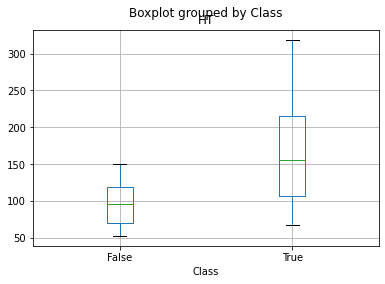

In [5]:
df_feat.groupby(["SubjectID","SessionID"]).mean().boxplot(column=['HT'],by="Class" )

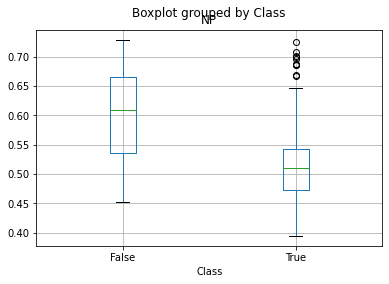

In [6]:
df_feat.groupby(["SubjectID","SessionID"]).mean().boxplot(column=['NP'],by="Class")

In [7]:
df_nft = df_nft.drop(df_nft[(df_nft.SubjectID ==26) & (df_nft.SessionID == 11)].index)
df_nft = df_nft.drop(df_nft[(df_nft.SubjectID ==32) & (df_nft.SessionID == 5)].index)
df_nft = df_nft.drop(df_nft[(df_nft.SubjectID ==16)].index)

<Figure size 144x216 with 0 Axes>

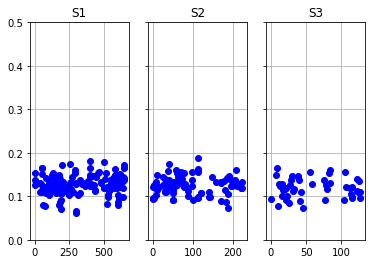

In [8]:
SUBJECT = 2
time_1 = df_nft.loc[(df_nft.SubjectID == SUBJECT) & (df_nft.SessionID ==1)].Time
NP_1 = df_nft.loc[(df_nft.SubjectID == SUBJECT) & (df_nft.SessionID ==1)].HT/1000
time_2 = df_nft.loc[(df_nft.SubjectID == SUBJECT) & (df_nft.SessionID ==2)].Time
NP_2 = df_nft.loc[(df_nft.SubjectID == SUBJECT) & (df_nft.SessionID ==2)].HT/1000
time_3 = df_nft.loc[(df_nft.SubjectID == SUBJECT) & (df_nft.SessionID ==3)].Time
NP_3 = df_nft.loc[(df_nft.SubjectID == SUBJECT) & (df_nft.SessionID ==3)].HT/1000
pt.figure(num=None, figsize=(2, 3), facecolor='w', edgecolor='k')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_ylim((0,0.5))
ax2.set_ylim((0,0.5))
ax3.set_ylim((0,0.5))
ax1.grid()
ax2.grid()
ax3.grid()
ax1.plot(time_1, NP_1,'bo', c = 'b')
ax1.set_title("S1")
ax2.plot(time_2, NP_2,'bo', c = 'b')
ax2.set_title("S2")
ax3.plot(time_3, NP_3,'bo', c = 'b')
ax3.set_title("S3")

ax3.label_outer()
ax2.label_outer()
plt.savefig('/content/gdrive/MyDrive/TFM/PD_HT.eps', format='eps')



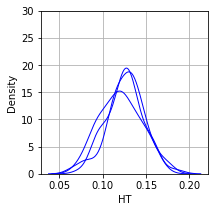

In [9]:
import seaborn as sns
plt.figure(num=None, figsize=(3, 3),facecolor='w', edgecolor='k')
sns.distplot(NP_1, hist=False, kde=True, 
             bins=int(180/5), color = 'b', 
             kde_kws={'linewidth': 1})
sns.distplot(NP_2, hist=False, kde=True, 
             bins=int(180/5), color = 'b', 
             kde_kws={'linewidth': 1})
sns.distplot(NP_3, hist=False, kde=True, 
             bins=int(180/5), color = 'b', 
             kde_kws={'linewidth': 1})
plt.ylim((0,30))
plt.grid()
plt.savefig('/content/gdrive/MyDrive/TFM/PD_HT_density.eps', format='eps')

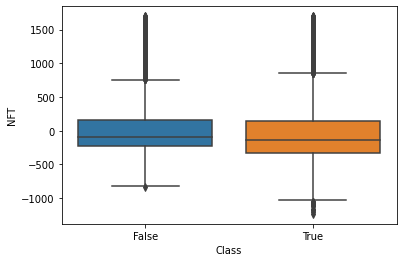

In [10]:
sns.boxplot(x=df_nft["Class"], y=df_nft["NFT"] )
plt.savefig('/content/gdrive/MyDrive/TFM/NFT_box.eps', format='eps')

In [11]:
def class_def(element):
    label=0
    if element in pd_patients:
        label=1
    return label

def obtain_stats(input_df, variable,min_elem):
    df = pd.DataFrame()
    prev_subject = 0
    prev_session = 0
    name_variable= input_df.columns[variable]
    window_time = 15 #CAN BE CHANGED
    first_index = []
    for subject, session in input_df.groupby(["SubjectID","SessionID"]): 
        iterkey_new = session.iterrows()
        n=0
        window = []
        for index, row in iterkey_new:
            if row.SubjectID != prev_subject or row.SessionID != prev_session:
                first_index = index
                prev_subject = row.SubjectID
                prev_session = row.SessionID
            
            if (input_df.loc[index].Time<window_time*(n+1)+input_df.loc[first_index].Time) and (input_df.loc[index].Time>=window_time*(n)+input_df.loc[first_index].Time):
                if math.isnan(input_df.loc[index].iloc[variable])==0:
                    window.append(input_df.loc[index].iloc[variable])
            else:
                if len(window)>=min_elem:
                    data = {'Mean': statistics.mean(window), 'Median': statistics.median(window), 'SD': np.std(window),'Skewness': skew(window),'Kurtosis': kurtosis(window),'SessionID': row.SessionID , 'SubjectID': row.SubjectID}
                    df = df.append(pd.DataFrame(data, columns = ["Mean","Median","SD","Skewness","Kurtosis","SessionID","SubjectID"] , index=[0]))
                window = []
                window.append(input_df.loc[index].iloc[variable])
                n += 1
        if len(window)>=min_elem:
            data = {'Mean': statistics.mean(window), 'Median': statistics.median(window), 'SD': np.std(window),'Skewness': skew(window),'Kurtosis': kurtosis(window),'SessionID': row.SessionID , 'SubjectID': row.SubjectID}
            df = df.append(pd.DataFrame(data, columns = ["Mean","Median","SD","Skewness","Kurtosis","SessionID","SubjectID"] , index=[0]))
    
    df_session_mean = df.groupby(["SubjectID","SessionID"]).mean()
    df_session_std = df.groupby(["SubjectID","SessionID"]).std()
    df_session_mean.columns = [name_variable+" Mean",name_variable+" Median",name_variable+" SD",name_variable+" Skewness",name_variable+" Kurtosis"]
    df_session_std.columns = [name_variable+" SD Mean",name_variable+" SD Median",name_variable+" SD SD",name_variable+" SD Skewness",name_variable+" SD Kurtosis"]
    df_session = pd.concat([df_session_mean, df_session_std], axis=1)
    df_session['Class'] = np.zeros(len(df_session))
    df_session['Class']= list(map(class_def, df_session.index.get_level_values('SubjectID').values))
    return df_session

In [12]:
df_NFT = obtain_stats(df_nft,7,1)


In [ ]:
df_NFT.to_csv("/content/gdrive/MyDrive/TFM/df_NFT.csv")

In [13]:
df_NP = obtain_stats(df_feat,0,2)
df_HT = obtain_stats(df_feat,1,2)

In [14]:
## Velocity and acceleration
df_new = pd.DataFrame()
count = 0
for subject, session in df_feat.groupby(["SubjectID","SessionID"]): 
    iterkey_new = session.iterrows()
    n_elements = 5 #CAN BE CHANGED
    size = 0
    window_v = []
    for index,row in iterkey_new: 
        if size==0:
            time_begin = df_feat.loc[index].Time
            size += 1
        elif size < n_elements:
            size += 1
        else:
            time_end = df_feat.loc[index].Time
            size = 0
            data_v = {'Velocity': n_elements/(time_end - time_begin), 'Acceleration': n_elements/(time_end - time_begin)**2,'Time': time_begin,'SessionID': row.SessionID , 'SubjectID': row.SubjectID}
            df_new = df_new.append(pd.DataFrame(data_v, columns = ["Velocity","Acceleration","Time","SessionID","SubjectID"], index=[count]))
            count+=1

In [15]:
df_v = obtain_stats(df_new,0,1)
df_a = obtain_stats(df_new,1,2)

In [16]:
df_v

Velocity Mean  ...  Class
SubjectID SessionID                 ...       
1.0       1.0             0.773873  ...      1
          2.0             0.914206  ...      1
          3.0             0.767016  ...      1
          4.0             1.082144  ...      1
          5.0             0.748542  ...      1
...                            ...  ...    ...
33.0      6.0             2.816752  ...      0
          7.0             2.854151  ...      0
          8.0             2.360886  ...      0
          9.0             2.889104  ...      0
          10.0            2.933685  ...      0

[331 rows x 11 columns]

In [17]:
df_feat["PChange"] = df_feat.groupby(["SubjectID","SessionID"]).NP.diff()
df_feat["PJerk"] = df_feat.groupby(["SubjectID","SessionID"]).NP.diff().diff()
df_pc = obtain_stats(df_feat,7,1)
df_pj = obtain_stats(df_feat,8,1)

In [ ]:
df_pj

PJerk Mean  PJerk Median  ...  PJerk SD Kurtosis  Class
SubjectID SessionID                            ...                          
1         1           -0.000961 -2.236842e-02  ...           0.522798      1
          2            0.008739  3.469447e-17  ...           0.317202      1
          3           -0.000472 -4.249998e-02  ...           0.640709      1
          4            0.000388  1.562513e-03  ...           0.125755      1
          5            0.002654 -2.499998e-02  ...           0.725180      1
...                         ...           ...  ...                ...    ...
33        6            0.003428 -4.166683e-03  ...           0.553318      0
          7            0.000981 -2.000000e-08  ...           0.280670      0
          8            0.000345 -3.437499e-02  ...           0.342955      0
          9            0.005814 -4.166680e-03  ...           0.599857      0
          10           0.006771 -5.312499e-02  ...           0.408270      0

[331 rows x 11 columns]

In [30]:
data = pd.concat([df_NP,df_HT.iloc[:,0:-1],df_NFT.iloc[:,0:-1],df_v.iloc[:,0:-1],df_a.iloc[:,0:-1],df_pc.iloc[:,0:-1],df_pj.iloc[:,0:-1]], axis=1)

X = data.drop(['Class'], axis=1)
y = np.array(data.Class)
a = data.groupby(["SubjectID"]).size()
#y = label_binarize(y, classes=[0, 1])
groups = data.index.get_level_values('SubjectID').values

In [34]:
os.chdir("/content/gdrive/MyDrive/TFM")
#os.chdir("/Users/mariabaeza/Desktop/Universidad/BigData/TFM")
pd_patients = [1,2,3,4,5,6,7,8,9,10,13,14,16,17,18,19,20,21]
import pickle
# Saving the objects:
with open('features.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([data,X,y,a,groups, pd_patients], f)